## Goal

I find an improved implementation of anchor-word algorithm at https://aclanthology.org/D19-1504.pdf . I want to see how well it performs on a simulated dataset that satsifies the "anchor-word" assumption. 

In [1]:
import os
import sys
import pandas as pd
from scipy import sparse
from sklearn.decomposition import NMF, LatentDirichletAllocation

import numpy as np
import matplotlib.pyplot as plt

script_dir = "../"
sys.path.append(os.path.abspath(script_dir))
from file2 import *
from factorize import *
from smallsim_functions_anchor import *
from misc import *


np.random.seed(123)

## small, uncorrelated example

In [2]:
n = 1000
p = 5000
k = 4
doc_len = 100

sim = smallsim_independent(n = n, p = p, k = k, doc_len = doc_len)
X = sparse.coo_matrix(sim["X"])
L = sim["L"]
F = sim["F"]

Bows = X2Bows(X)
C, D1, D2 = bows2C(Bows, min_tokens=0)

[file.bows2C] Start constructing dense C...
- Counting the co-occurrence for each document...
+ Finish constructing C and D!
  - The sum of all entries = 1.000000
  - Elapsed Time = 1.1234 seconds


In [3]:
S, B, A, Btilde, Cbar, C_rowSums, diagR, C = factorizeC(C, K=k, rectifier='AP', optimizer='activeSet')

+ Start rectifying C...
+ Start alternating projection
  - 1-th iteration... (3.165856e-04 / 5.011343e-08)
  - 2-th iteration... (1.789217e-07 / 5.011347e-08)
  - 3-th iteration... (1.515935e-07 / 5.011353e-08)
  - 4-th iteration... (1.310905e-07 / 5.011360e-08)
  - 5-th iteration... (1.148025e-07 / 5.011367e-08)
  - 6-th iteration... (1.015398e-07 / 5.011375e-08)
  - 7-th iteration... (9.057798e-08 / 5.011383e-08)
  - 8-th iteration... (8.139293e-08 / 5.011391e-08)
  - 9-th iteration... (7.356784e-08 / 5.011398e-08)
  - 10-th iteration... (6.683188e-08 / 5.011406e-08)
  - 11-th iteration... (6.100828e-08 / 5.011413e-08)
  - 12-th iteration... (5.595236e-08 / 5.011419e-08)
  - 13-th iteration... (5.150654e-08 / 5.011426e-08)
  - 14-th iteration... (4.758063e-08 / 5.011432e-08)
  - 15-th iteration... (4.408136e-08 / 5.011438e-08)
+ Finish alternating projection
  - Elapsed seconds = 23.1980

  - Finish rectifying C! [23.198041]
+ Start finding the set of anchor bases S...
[inference.fin

## Evaulate results

In [4]:
topic_idx = match_topics(F, B).astype(int)
topic_idx

array([2, 3, 1, 0])

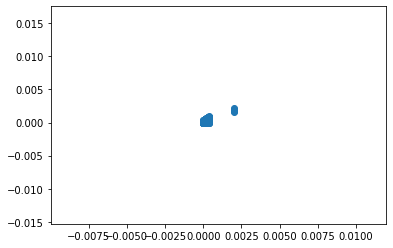

In [5]:
plt.scatter(F.flatten(), B[:,topic_idx].flatten())

In [6]:
S[topic_idx]

array([1379,  287, 2930, 4710])

In [7]:
F[:k, :]

array([[0.0020048 , 0.        , 0.        , 0.        ],
       [0.        , 0.00199237, 0.        , 0.        ],
       [0.        , 0.        , 0.00199201, 0.        ],
       [0.        , 0.        , 0.        , 0.00200393]])

In [8]:
B[:k, topic_idx]

array([[1.80236981e-03, 0.00000000e+00, 9.78218461e-06, 2.60008535e-05],
       [1.29318665e-05, 1.87358290e-03, 0.00000000e+00, 6.45415519e-05],
       [3.61063390e-04, 0.00000000e+00, 1.52208183e-03, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 2.96739657e-05, 2.25273239e-03]])

In [ ]:
B[np.ix_(S[topic_idx],topic_idx)].round(4)

In [10]:
# compare A and LLt/n
A_reorder = A[topic_idx,:]
A_reorder = A_reorder[:, topic_idx]
A_reorder.round(decimals=2)

array([[0.22, 0.02, 0.  , 0.01],
       [0.02, 0.2 , 0.02, 0.01],
       [0.  , 0.02, 0.22, 0.01],
       [0.01, 0.01, 0.01, 0.21]])

In [11]:
L = sim["L"]
(L.T.dot(L)/n).round(decimals=2)

array([[0.17, 0.03, 0.02, 0.02],
       [0.03, 0.19, 0.02, 0.02],
       [0.02, 0.02, 0.18, 0.02],
       [0.02, 0.02, 0.02, 0.18]])

LDA can find those anchor words very well too

In [12]:
# lda = LatentDirichletAllocation(n_components=k, max_iter=20,
#                                 random_state=0)
# lda.fit(X)

# B2 = (lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]).T
# idx = match_topics(B2, F).astype(int)
# B2[anchor_words[idx],:].round(3)

In [13]:
Lam = L @ F.T
C_true = Lam.T @ Lam
C_true = C_true/C_true.sum()

In [14]:
# u, s, vh = np.linalg.svd(C)
# u0, s0, vh0 = np.linalg.svd(C_true)

KeyboardInterrupt: 